## Global signal basic calibration
_Phil Bull, 2023-01-04_

Apply a simple noise diode-based calibration to simulated global signal data.

In [1]:
import numpy as np
import scipy.optimize
import pylab as plt
import h5py

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
# Settings
fname = "sim_global_airy_diode10sec.hdf5"

### Load data

In [3]:
with h5py.File(fname, 'r') as f:
    
    # Print datasets and attributes
    for field in f.keys():
        print(field)
        for attr in f[field].attrs.keys():
            print("  | %s: %s" % (attr, f[field].attrs[attr]))
    
    # Load data
    d = np.array(f['data'][:])
    ndiode_mask = np.array(f['ndiode_mask'][:])
    
    freqs = np.array(f['freqs'][:])
    times = np.array(f['times'][:])
    lsts = np.array(f['lsts'][:])
    
    # Metadata
    obstime = str(f['data'].attrs['obstime'])
    location = str(f['data'].attrs['location'])
    Tdiode = float(f['ndiode_mask'].attrs['Tdiode_Kelvin'])
    
print("")
print("Data shape:", d.shape)
print("Obstime:   ", obstime)
print("Location:  ", location)
print("")
print("Freqs: %6.3f - %6.3f MHz (%d)" % (freqs[0], freqs[-1], freqs.size))
print("LSTs:  %6.3f - %6.3f rad (%d)" % (lsts[0], lsts[-1], lsts.size))
print("Times: %6.3f - %6.3f sec (%d)" % (times[0], times[-1], times.size))

data
  | location: (3822712.88544561, -153832.37979807, 5086301.58702797) m
  | obstime: 2022-10-21 07:59:59.712
  | site_height_m: 77.0
  | site_lat_deg: 53.235002
  | site_lon_deg: -2.3044349
  | units: K
freqs
  | units: MHz
lsts
  | units: rad
ndiode_mask
  | Tdiode_Kelvin: 1000.0
times
  | units: s

Data shape: (3600, 280)
Obstime:    2022-10-21 07:59:59.712
Location:   (3822712.88544561, -153832.37979807, 5086301.58702797) m

Freqs: 60.000 - 88.000 MHz (280)
LSTs:   2.573 -  3.098 rad (3600)
Times:  0.000 - 7200.000 sec (3600)


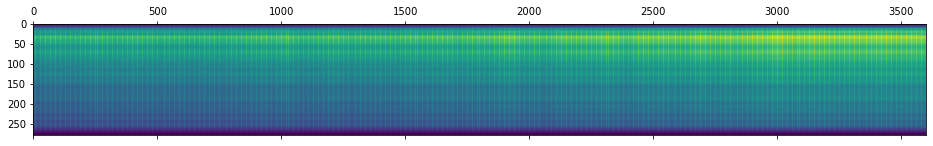

In [4]:
plt.matshow(d.T, aspect='auto')

### Extract masks

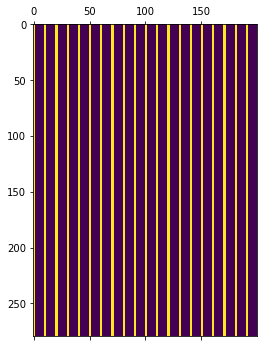

[  0. 280.]
[ True  True False ... False False False]
[280. 280.   0. ...   0.   0.   0.]


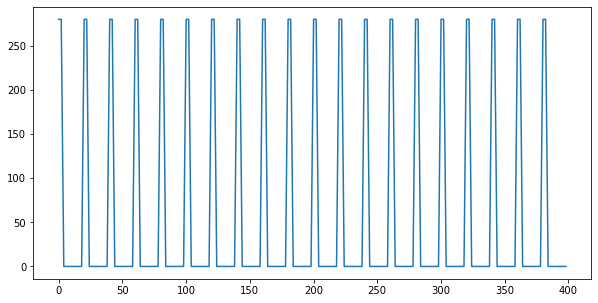

In [5]:
# Plot noise diode mask (beware aliasing)
plt.matshow(ndiode_mask.T[:,:200], aspect='auto')
plt.show()

# Plot noise diode mask as 1D time series only
ndiode_mask_time = np.sum(ndiode_mask, axis=1)
plt.plot(times[:200], ndiode_mask_time[:200])
#plt.xlim((0., 50.))

# Check that mask has only 2 states
print(np.unique(ndiode_mask_time))
assert np.unique(ndiode_mask_time).size == 2

# Convert to bool
ndiode_mask_time = ndiode_mask_time.astype('bool')
print(ndiode_mask_time)
print(np.sum(ndiode_mask, axis=1))

Text(0.5, 0, 'Freq.')

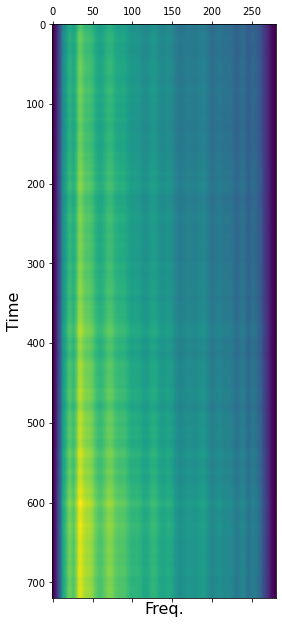

In [6]:
# Plot data with noise diode on only
plt.matshow(d[ndiode_mask_time,:], aspect='auto')
plt.ylabel("Time", fontsize=16)
plt.xlabel("Freq.", fontsize=16)

In [7]:
d.shape

(3600, 280)

### Joint fit of smooth gain, bandpass, and foregrounds

In [8]:
def data_model(params, data, diode_mask, Tdiode, Ngain, Nbandpass, Nfg):
    
    # Scales time/freq. variables
    x_time = np.linspace(-1., 1., data.shape[0])
    x_freq = np.linspace(-1., 1., data.shape[1])
    
    # Extract parameters
    pgain = params[:Ngain]
    pbandpass = params[Ngain:Ngain+Nbandpass]
    pfg = params[Ngain+Nbandpass:Ngain+Nbandpass+Nfg]
    
    # Construct models
    y_gain = np.poly1d(pgain)(x_time)
    y_bandpass = np.poly1d(pbandpass)(x_freq)
    
    # Construct diode model
    diode_model = Tdiode * diode_mask
    
    # Construct calibrated data model
    # FIXME

In [9]:
def get_chunks(diode_mask):
    ndiode_on_chunks = []
    ndiode_off_chunks = []
    cur_chunk = []
    cur_state = diode_mask[0] # start in the initial state
    
    # Loop over mask elements
    for i in np.arange(diode_mask.size):
        if diode_mask[i] == cur_state:
            # Still in the previous chunk
            cur_chunk.append(i)
        else:
            # New chunk has started; flush the old chunk
            if cur_state == 1:
                ndiode_on_chunks.append(np.array(cur_chunk))
            else:
                ndiode_off_chunks.append(np.array(cur_chunk))
            
            cur_state = diode_mask[i]
            cur_chunk = []
            cur_chunk.append(i)
            
    return ndiode_on_chunks, ndiode_off_chunks

# Get continguous blocks of times where the noise diode is on and off
ndiode_on, ndiode_off = get_chunks(ndiode_mask_time)

In [10]:
# Calculate bandpass by differencing between leading and trailing samples of the block
deltas = [] # difference between ndiode on and off states (neighbouring time samples)
t_deltas = [] # time at the boundary between the states
for block in ndiode_on:
    
    if block[0] != 0:
        delta_leading = d[block[0]] - d[block[0]-1]
        deltas.append(delta_leading)
        t_deltas.append(0.5 * (times[block[0]] + times[block[0]-1]))
    
    if block[-1] != times.size-1:
        delta_trailing = d[block[-1]] - d[block[-1]+1]
        deltas.append(delta_trailing)
        t_deltas.append(0.5 * (times[block[-1]] + times[block[-1]+1]))

# Convert to numpy arrays
t_deltas = np.array(t_deltas)
deltas = np.array(deltas)

Text(0.5, 0, 'Time')

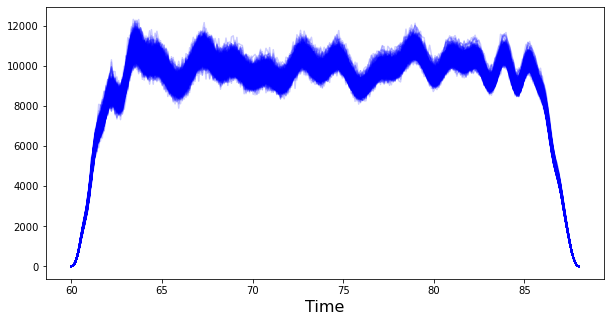

In [11]:
plt.plot(freqs, deltas.T, 'b-', alpha=0.2)
plt.xlabel("Time", fontsize=16)

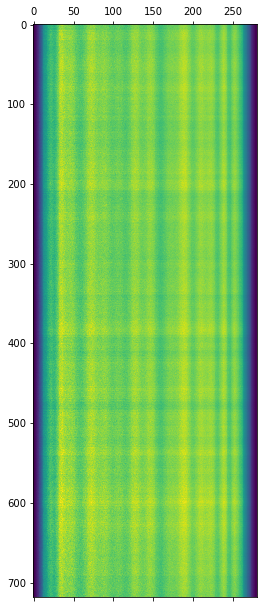

In [45]:
# Calculate effective gain by assuming a noise diode that is constant in time and frequency
# delta(nu, t) = gain(nu, t) T_diode
gain_est = deltas / Tdiode

plt.matshow(gain_est, aspect='auto')

In [51]:
# Fit 2D factorisable polynomial to gains estimated from differencing
def bandpass_model(params, freqs):
    x_freq = np.linspace(-1., 1., freqs.size)
    return np.poly1d(params)(x_freq)


def gain_time_model(params, times):
    x_times = np.linspace(-1., 1., times.size)
    return np.poly1d(params)(x_times)


def gain_model(params, times, freqs, Ngain, Nbandpass):
    
    # Extract parameters
    pgain = params[:Ngain]
    pbandpass = params[Ngain:Ngain+Nbandpass]
    
    # Construct models
    y_gain = gain_time_model(pgain, times)
    y_bandpass = bandpass_model(pbandpass, freqs)
    
    # Construct gain model
    return y_gain[:,np.newaxis] * y_bandpass[np.newaxis,:]


# Define log-likelihood function
logl = lambda p, times, freqs, Ngain, Nbandpass: -0.5 * ((gain_est - gain_model(p, times, freqs, Ngain, Nbandpass))**2.).flatten()

# Choose order of polynomial functions
Ngain = 50
Nbandpass = 30 #18

# Run least-squares fitting
p0 = np.ones(Ngain + Nbandpass)
params, _ = scipy.optimize.leastsq(logl, p0, args=(t_deltas, freqs, Ngain, Nbandpass))

# Extract parameters
pgain = params[:Ngain]
pbandpass = params[Ngain:Ngain+Nbandpass]


# FIXME: Need to fire noide diode more rapidly than the 1/f correlation time! 
# Otherwise smaller-scale correlated gain structure can't be recovered...

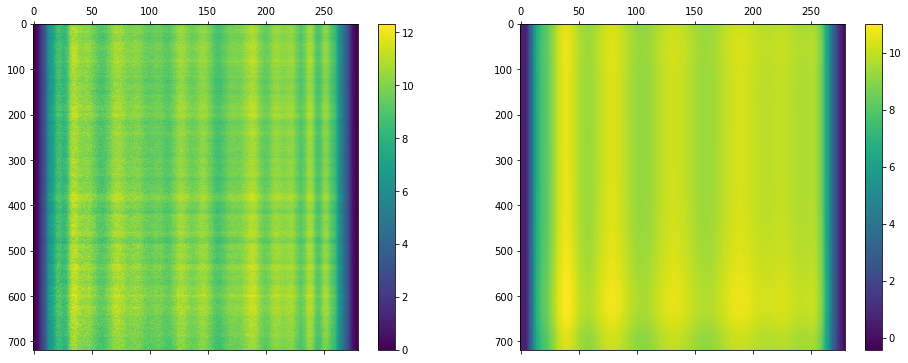

In [52]:
# Plot gain estimated from differencing vs smooth model
gain_bestfit = gain_model(params, t_deltas, freqs, Ngain=Ngain, Nbandpass=Nbandpass)

plt.subplot(121)
plt.matshow(gain_est, aspect='auto', fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(gain_bestfit, aspect='auto', fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 6.))

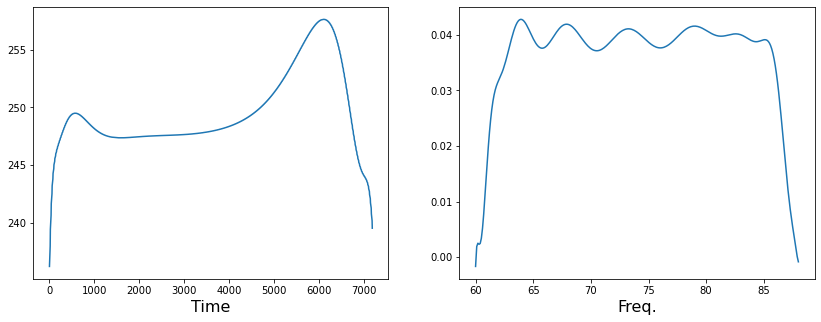

In [53]:
# Plot bandpass and gains only
plt.subplot(121)
plt.plot(t_deltas, gain_time_model(pgain, t_deltas))
plt.xlabel('Time', fontsize=16)

plt.subplot(122)
plt.plot(freqs, bandpass_model(pbandpass, freqs))
plt.xlabel('Freq.', fontsize=16)
plt.gcf().set_size_inches((14., 5.))

In [54]:
with h5py.File("sim_global_airy_diode10sec.sim.hdf5", 'r') as f:
    bandpass_truth = np.array(f['bandpass'][:])

/tmp/ipykernel_38743/3977454966.py:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(freqs, (bp / np.sum(bp)) / (bandpass_truth / np.sum(bandpass_truth)) - 1., lw=1.8)


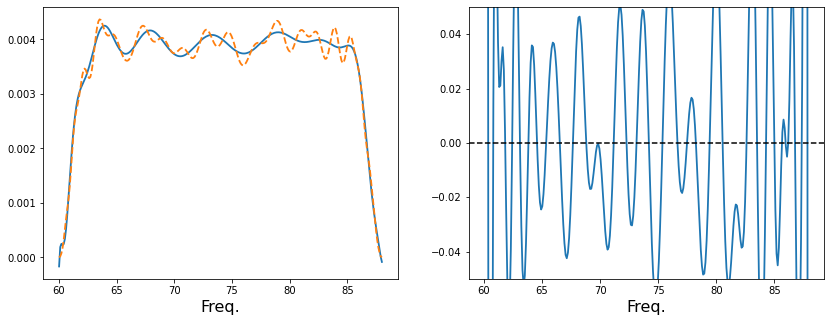

In [55]:
plt.subplot(121)
bp = bandpass_model(pbandpass, freqs)
plt.plot(freqs, bp / np.sum(bp), lw=1.8)
plt.plot(freqs, bandpass_truth / np.sum(bandpass_truth), lw=1.8, ls='dashed')
plt.xlabel('Freq.', fontsize=16)

plt.subplot(122)
plt.plot(freqs, (bp / np.sum(bp)) / (bandpass_truth / np.sum(bandpass_truth)) - 1., lw=1.8)
plt.axhline(0., ls='dashed', color='k')
plt.ylim((-0.05, 0.05))
plt.xlabel('Freq.', fontsize=16)

plt.gcf().set_size_inches((14., 5.))

In [27]:
with h5py.File("sim_global_airy_diode10sec.sim.hdf5", 'r') as f:
    gain_corr_truth = np.array(f['gain_corr'][:])

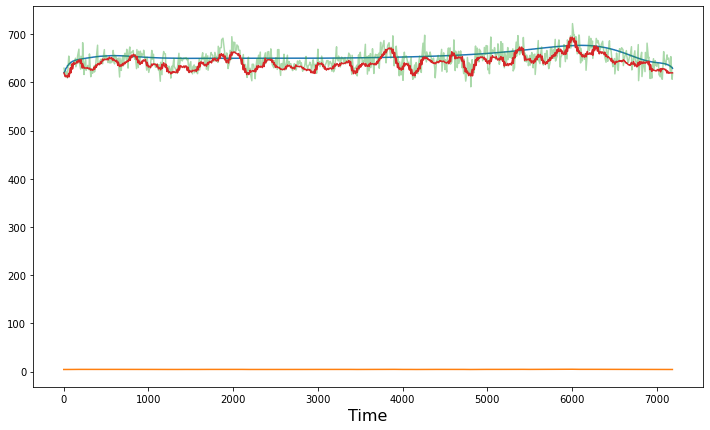

In [28]:
# Time indices when the noise diode is on
idxs_ndiode_on = np.concatenate(ndiode_on)

# Average the gains
gain_est_avg = np.mean(gain_est[:,:]/bp[:], axis=1)

# Plot bandpass and gains only
plt.subplot(111)
plt.plot(t_deltas, gain_time_model(pgain, t_deltas))
plt.plot(times[idxs_ndiode_on], gain_corr_truth[idxs_ndiode_on]*4.35)
plt.plot(t_deltas, gain_est[:,100]/bp[100], alpha=0.4)
plt.plot(t_deltas, gain_est_avg) #*0.8)

plt.xlabel('Time', fontsize=16)
plt.gcf().set_size_inches((12., 7.))

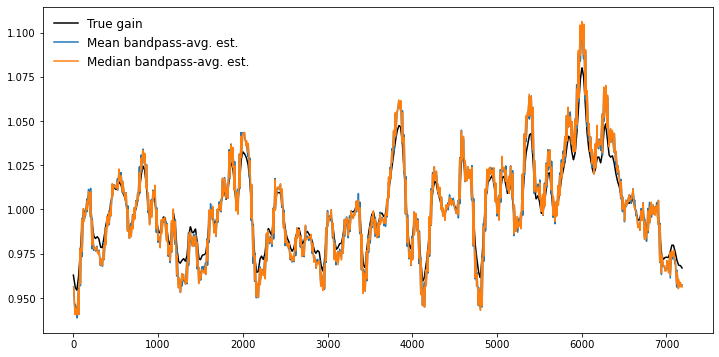

In [31]:
gain_est_bpcorr = gain_est[:,:] / bp[:]
for i in range(gain_est_bpcorr.shape[1]):
    gain_est_bpcorr[:,i] -= np.mean(gain_est_bpcorr[:,i])

# True gains
plt.plot(times[idxs_ndiode_on], gain_corr_truth[idxs_ndiode_on], color='k', label="True gain")

# Mean and median of bandpass-averaged estimate
plt.plot(t_deltas, 1. + np.mean(gain_est_bpcorr, axis=1) / 500., label="Mean bandpass-avg. est.")
plt.plot(t_deltas, 1. + np.median(gain_est_bpcorr, axis=1) / 500., label="Median bandpass-avg. est.")

plt.legend(loc='upper left', frameon=False, prop={'size': 'large'})
plt.gcf().set_size_inches(12., 6.)

### Use GPR to fit time-dependent gain

In [21]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern

GPR score (train): 0.9454621826976636
WhiteKernel(noise_level=0.0668) + RBF(length_scale=0.00784) + RBF(length_scale=0.0934)


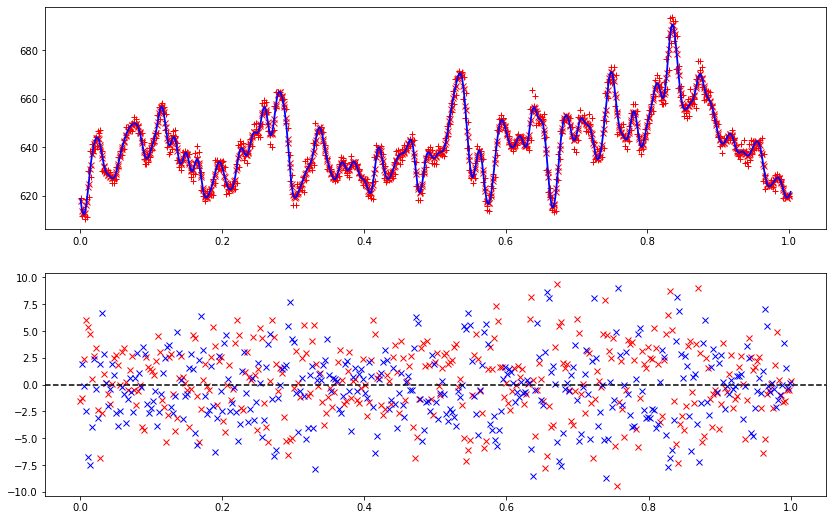

In [22]:
# Construct kernel
kernel = WhiteKernel() + RBF(0.005) + RBF(0.1) #DotProduct()

# Perform optimisation using leading-edge(?) noise diode samples
X1 = np.atleast_2d(t_deltas[:]).T / np.max(t_deltas)
y1 = gain_est_avg[:]
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=0).fit(X1, y1)
print("GPR score (train):", gpr.score(X1, y1))

# Predict for trailing-edge samples
X2 = np.atleast_2d(times).T / np.max(t_deltas)
y1_mean_pred = gpr.predict(X1, return_std=False)
y2_mean_pred = gpr.predict(X2, return_std=False)

print(gpr.kernel_)

# Plot fits and residuals
plt.subplot(211)
plt.plot(X1, y1, 'r+')
plt.plot(X1, y1_mean_pred, 'rx', lw=1.8)
plt.plot(X2, y2_mean_pred, 'b-', lw=1.8)

plt.subplot(212)
plt.plot(X1[::2], (y1_mean_pred - y1)[::2], 'rx', lw=1.8)
plt.plot(X1[1::2], (y1_mean_pred - y1)[1::2], 'bx', lw=1.8)
plt.axhline(0., color='k', ls='dashed')
#plt.plot(X2, y2_mean_pred, 'b-', lw=1.8)

plt.gcf().set_size_inches((14., 9.))

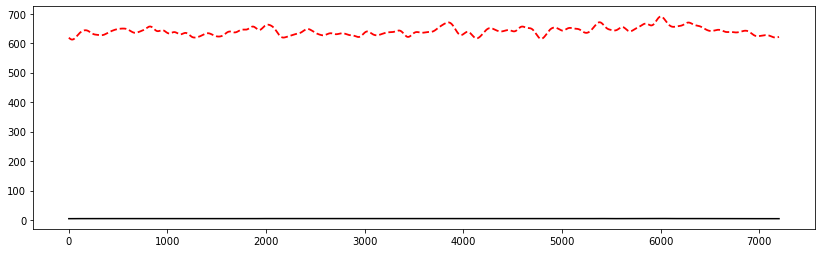

In [23]:
plt.subplot(211)
plt.plot(times, gain_corr_truth * 5.3, color='k', label="True gain")
plt.plot(X2*np.max(t_deltas), y2_mean_pred, 'r--', lw=1.8)
plt.gcf().set_size_inches((14., 9.))

In [32]:
# Use this as the time-dep. gain estimate
# Normalise by 
g_time_est = y2_mean_pred.copy()

## Subtract foregrounds from calibrated data

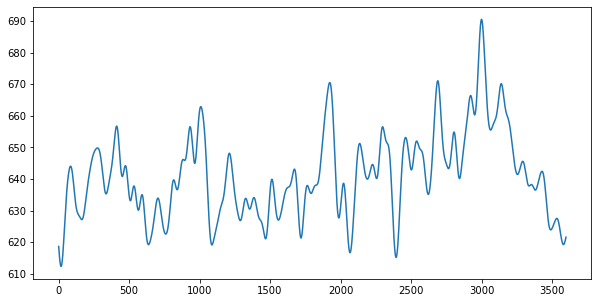

In [42]:
plt.plot(g_time_est)

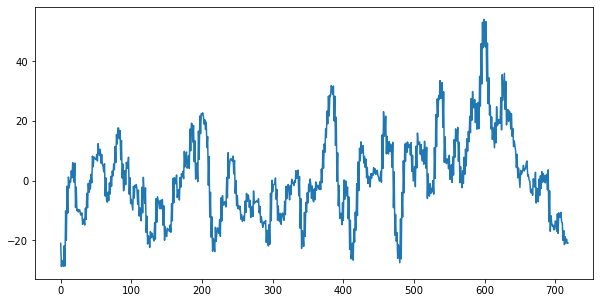

In [43]:
plt.plot(g_bandpass_est)

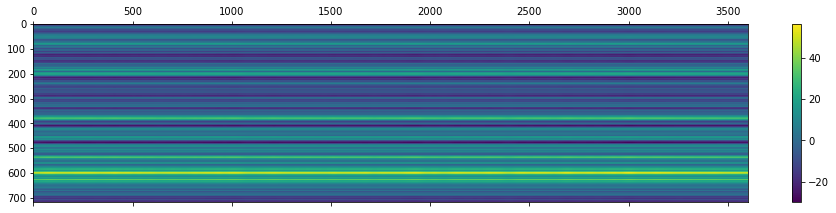

In [39]:
# Calculate overall gain factor and divide by its rms to normalise
gain_est = g_time_est[:,np.newaxis] * g_bandpass_est[np.newaxis,:]
gain_est_rms = np.sqrt(np.mean(gain_est**2.))
gain_est /= gain_est_mean

# Plot result
plt.matshow(gain_est.T, aspect='auto')
plt.colorbar()

In [ ]:
d_cal = d / (g_time_est[:,np.newaxis] * g_bandpass_est[np.newaxis,:])

In [34]:
d.shape, g_time_est.shape

((3600, 280), (3600,))

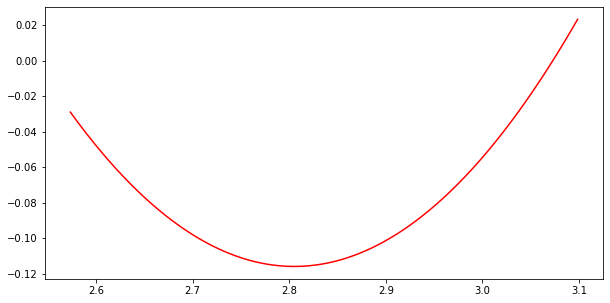

In [73]:
plt.plot(lsts, chebyshev_model(lsts, ncoeffs=3, amp=0.1), 'r-')

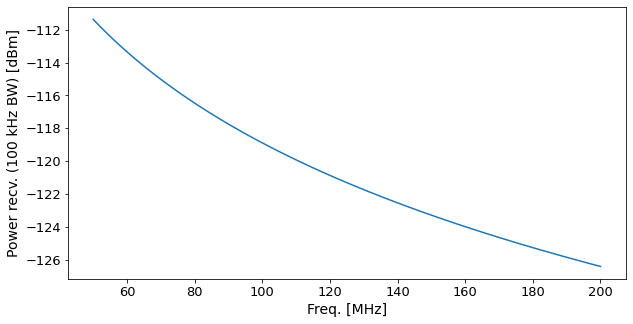

In [68]:
def temperature_to_dbm(Tant, bw):
    """
    Parameters:
        Tant (float):
            T_ant in Kelvin.
        freq (float):
            Observing frequency, in MHz.
        bw (float):
            Bandwidth in MHz.
    """
    # Power = kB T delta_nu
    
    # Flux density
    kB = 1.380649e-23 # m^2 kg s^-2 K^-1
    power = kB * Tant * (bw * 1e6) # Watts
    #print("Flux density: %6.3e Jy" % S)
    
    # Convert to dBm, which is decibel-milliWatts
    dbm = 10.*np.log10(power * 1e3)
    return dbm

# Sky temperature
Tsky = lambda freq: 60. * (freq/300.)**(-2.5) # Kelvin

# Plot dBm vs freq.
freqs = np.linspace(50., 200., 1000)
dbm = temperature_to_dbm(Tsky(freqs), bw=0.1)

plt.subplot(111)
plt.plot(freqs, dbm)
plt.ylabel("Power recv. (100 kHz BW) [dBm]", fontsize=14)
plt.xlabel("Freq. [MHz]", fontsize=14)
plt.tick_params(which='both', labelsize=13)